In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import datetime

In [2]:
pm25_data = pd.read_excel('dataset/PM2.5/PM2.5(2019).xlsx', sheet_name='PM2.5')

In [3]:
missing_percentage = (pm25_data.isnull().sum() / len(pm25_data))
columns_to_drop = missing_percentage[missing_percentage > .5].index.tolist()
pm25_data = pm25_data.drop(columns=columns_to_drop)

In [4]:
with open('dataset/PM2.5/northernStations.txt', 'r', encoding='utf-8') as f:
    stations_data = json.load(f)

In [5]:
northern_stations = pd.DataFrame(stations_data['northernStations'])
print(f"จำนวนสถานีวัด PM2.5 ในภาคเหนือ: {len(northern_stations)}")

จำนวนสถานีวัด PM2.5 ในภาคเหนือ: 24


In [6]:
valid_stations = northern_stations[northern_stations['id'].isin(pm25_data.columns)]
print(f"จำนวนสถานีภาคเหนือที่มีข้อมูล PM2.5: {len(valid_stations)}")

จำนวนสถานีภาคเหนือที่มีข้อมูล PM2.5: 15


In [7]:
fire_df = pd.read_csv('dataset/Fire/fire_archive_M-C61_606028.csv')

In [8]:
print(fire_df.shape)
fire_df.head()

(157257, 15)


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,18.8677,98.9765,326.0,2.1,1.4,2017-04-01,430,Terra,MODIS,79,6.03,292.8,52.6,D,2
1,18.1319,97.9888,315.2,1.8,1.3,2017-04-01,431,Terra,MODIS,41,6.03,297.7,13.2,D,0
2,18.0736,97.9770,315.4,1.8,1.3,2017-04-01,431,Terra,MODIS,33,6.03,296.9,13.9,D,0
3,16.8922,98.5144,321.0,2.1,1.4,2017-04-01,431,Terra,MODIS,61,6.03,296.6,13.1,D,0
4,14.3897,100.6942,305.5,1.4,1.2,2017-04-01,1523,Terra,MODIS,64,6.03,291.1,8.1,N,0


In [9]:
thailand_df = fire_df[(fire_df['latitude'] >= 5) & (fire_df['latitude'] <= 21) & 
                 (fire_df['longitude'] >= 97) & (fire_df['longitude'] <= 106)]

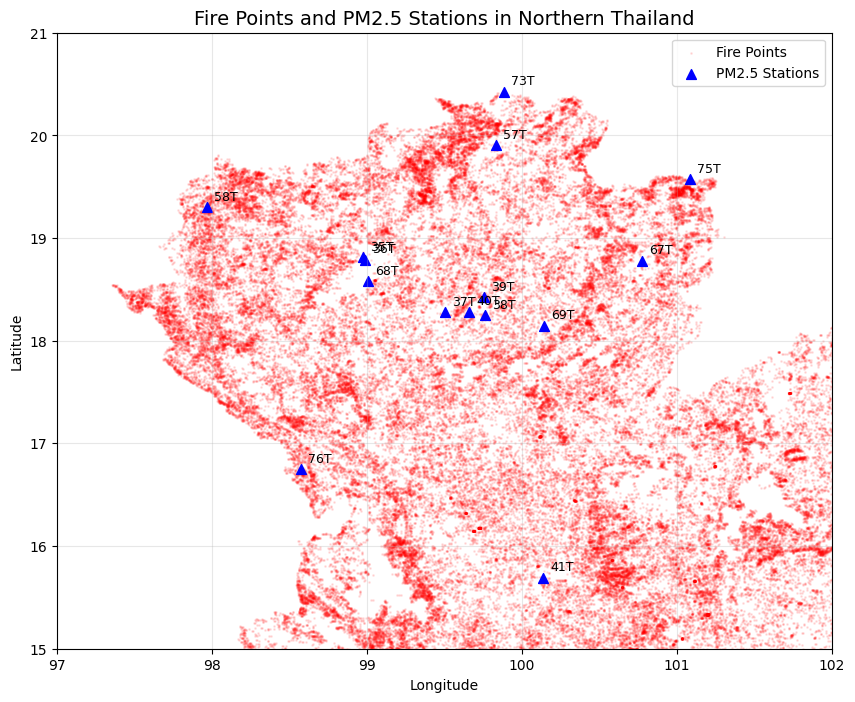

In [10]:
plt.figure(figsize=(10, 8))
plt.xlim(97, 102)
plt.ylim(15, 21)

# Plot fire points (reduce opacity to make station points clearer)
plt.scatter(fire_df['longitude'], fire_df['latitude'], 
           c='red', alpha=0.1, s=1, label='Fire Points')

# Plot PM2.5 station locations
plt.scatter(valid_stations['lng'], valid_stations['lat'], 
           c='blue', s=50, marker='^', label='PM2.5 Stations')

# Add station IDs to points
for _, station in valid_stations.iterrows():
    plt.annotate(station['id'], 
                xy=(station['lng'], station['lat']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9)

# Add map details
plt.title('Fire Points and PM2.5 Stations in Northern Thailand', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.legend()

## Select station

In [11]:
north_station = valid_stations.loc[valid_stations['lat'].idxmax()]  # เหนือสุด
south_station = valid_stations.loc[valid_stations['lat'].idxmin()]  # ใต้สุด
east_station = valid_stations.loc[valid_stations['lng'].idxmax()]   # ตะวันออกสุด
west_station = valid_stations.loc[valid_stations['lng'].idxmin()]   # ตะวันตกสุด


In [12]:
center_lat = valid_stations['lat'].mean()
center_lng = valid_stations['lng'].mean()
valid_stations['dist_to_center'] = np.sqrt(
    (valid_stations['lat'] - center_lat)**2 + 
    (valid_stations['lng'] - center_lng)**2
)
center_station = valid_stations.loc[valid_stations['dist_to_center'].idxmin()]

/var/folders/vg/p01w91952dv7q8gqp503xbk80000gn/T/ipykernel_25206/1793446745.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_stations['dist_to_center'] = np.sqrt(


In [13]:
# รวมสถานีที่เลือก (ตัดสถานีซ้ำออก)
selected_stations = [north_station, south_station, east_station, west_station, center_station]
# แปลงเป็น DataFrame และลบแถวซ้ำ
selected_df = pd.DataFrame(selected_stations).drop_duplicates(subset=['id'])

In [14]:
center_lat = (valid_stations['lat'].max() + valid_stations['lat'].min()) / 2
center_lng = (valid_stations['lng'].max() + valid_stations['lng'].min()) / 2

In [15]:
for area, condition in {
    'NW': (valid_stations['lat'] > center_lat) & (valid_stations['lng'] < center_lng),
    'NE': (valid_stations['lat'] > center_lat) & (valid_stations['lng'] > center_lng),
    'SW': (valid_stations['lat'] < center_lat) & (valid_stations['lng'] < center_lng),
    'SE': (valid_stations['lat'] < center_lat) & (valid_stations['lng'] > center_lng)
}.items():
    area_stations = valid_stations[condition]
    if len(area_stations) > 0 and not any(selected_df['id'].isin(area_stations['id'])):
        # เลือกสถานีที่อยู่ใกล้จุดกึ่งกลางของพื้นที่นั้น
        area_center_lat = area_stations['lat'].mean()
        area_center_lng = area_stations['lng'].mean()
        area_stations['dist'] = np.sqrt(
            (area_stations['lat'] - area_center_lat)**2 + 
            (area_stations['lng'] - area_center_lng)**2
        )
        closest_station = area_stations.loc[area_stations['dist'].idxmin()]
        selected_df = pd.concat([selected_df, pd.DataFrame([closest_station])])

/var/folders/vg/p01w91952dv7q8gqp503xbk80000gn/T/ipykernel_25206/811970182.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_stations['dist'] = np.sqrt(


In [16]:
selected_df

,id,name,location,lat,lng,dist_to_center,dist
8,73T,ต.เวียงพางคำ อ.แม่สาย จ.เชียงราย,สำนักงานสาธารณสุขอำเภอแม่สาย,20.427487,99.883592,NaN,NaN
6,41T,ต.ปากน้ำโพ อ.เมือง จ.นครสวรรค์,โครงการชลประทานนครสวรรค์,15.693050,100.136370,NaN,NaN
11,75T,ต.ห้วยโก๋น อ.เฉลิมพระเกียรติ จ.น่าน,โรงพยาบาลเฉลิมพระเกียรติ น่าน,19.575695,101.082069,NaN,NaN
9,58T,ต.จองคำ อ.เมือง จ.แม่ฮ่องสอน,สำนักงานทรัพยากรธรรมชาติและสิ่งแวดล้อมจังหวัดแ...,19.301370,97.970760,NaN,NaN
4,39T,ต.บ้านดง อ.แม่เมาะ จ.ลำปาง,โรงพยาบาลส่งเสริมสุขภาพตำบลท่าสี,18.427180,99.757746,0.187440,NaN
15,76T,ต.แม่ปะ อ.แม่สอด จ.ตาก,ศูนย์การศึกษานอกระบบอำเภอแม่สอด,16.746464,98.574374,2.062136,0.0


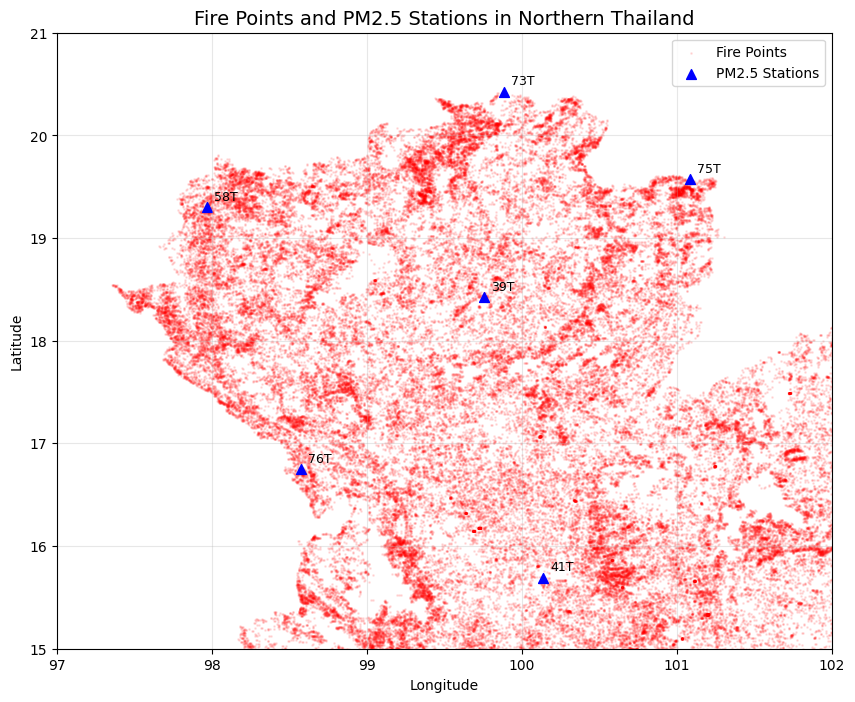

In [17]:
plt.figure(figsize=(10, 8))
plt.xlim(97, 102)
plt.ylim(15, 21)

# Plot fire points (reduce opacity to make station points clearer)
plt.scatter(fire_df['longitude'], fire_df['latitude'], 
           c='red', alpha=0.1, s=1, label='Fire Points')

# Plot PM2.5 station locations
plt.scatter(selected_df['lng'], selected_df['lat'], 
           c='blue', s=50, marker='^', label='PM2.5 Stations')

# Add station IDs to points
for _, station in selected_df.iterrows():
    plt.annotate(station['id'], 
                xy=(station['lng'], station['lat']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9)

# Add map details
plt.title('Fire Points and PM2.5 Stations in Northern Thailand', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.legend()

In [19]:
from math import sin, cos, radians, asin, sqrt, degrees, atan2

# สร้างฟังก์ชันสำหรับคำนวณจุดในรัศมีตามทิศที่กำหนด
def get_point_at_distance(lat, lng, distance_km, bearing_degrees):
    """
    คำนวณจุด lat, lng ใหม่ที่อยู่ห่างจากจุดเริ่มต้นตามระยะทางและทิศทางที่กำหนด
    
    Args:
        lat, lng: ละติจูดและลองจิจูดของจุดเริ่มต้น (องศา)
        distance_km: ระยะทางในหน่วยกิโลเมตร
        bearing_degrees: ทิศทางในหน่วยองศา (0=เหนือ, 90=ตะวันออก, 180=ใต้, 270=ตะวันตก)
    
    Returns:
        tuple: (lat, lng) ของจุดใหม่
    """
    R = 6371.0  # รัศมีของโลกในหน่วยกิโลเมตร
    
    lat1 = radians(lat)
    lon1 = radians(lng)
    bearing = radians(bearing_degrees)
    
    # คำนวณจุดใหม่
    distance_rad = distance_km / R
    
    lat2 = asin(sin(lat1) * cos(distance_rad) + 
                cos(lat1) * sin(distance_rad) * cos(bearing))
    
    lon2 = lon1 + atan2(sin(bearing) * sin(distance_rad) * cos(lat1),
                         cos(distance_rad) - sin(lat1) * sin(lat2))
    
    return (degrees(lat2), degrees(lon2))

# สร้างฟังก์ชันสำหรับสร้างจุดรอบสถานีวัด
def generate_points_around_station(station_lat, station_lng, inner_radius_km=20, outer_radius_km=50, num_directions=4):
    """
    สร้างจุด lat, lng ในรัศมีรอบสถานีวัดตามจำนวนทิศทางที่กำหนด
    
    Args:
        station_lat, station_lng: ละติจูดและลองจิจูดของสถานีวัด
        inner_radius_km: รัศมีวงในในหน่วยกิโลเมตร (default: 20)
        outer_radius_km: รัศมีวงนอกในหน่วยกิโลเมตร (default: 50)
        num_directions: จำนวนทิศทาง (4 หรือ 8, default: 8)
    
    Returns:
        pandas.DataFrame: DataFrame ที่มีคอลัมน์ lat, lng, radius, direction
    """
    points = []
    
    # เพิ่มจุดสถานีวัด
    points.append({
        'lat': station_lat,
        'lng': station_lng,
        'radius': 0,
        'direction': 'center',
        'description': 'สถานีวัด'
    })
    
    # กำหนดทิศทาง
    if num_directions == 4:
        bearings = [0, 90, 180, 270]  # N, E, S, W
        direction_names = ['north', 'east', 'south', 'west']
        direction_names_th = ['เหนือ', 'ตะวันออก', 'ใต้', 'ตะวันตก']
    else:  # 8 directions
        bearings = [0, 45, 90, 135, 180, 225, 270, 315]  # N, NE, E, SE, S, SW, W, NW
        direction_names = ['north', 'northeast', 'east', 'southeast', 'south', 'southwest', 'west', 'northwest']
        direction_names_th = ['เหนือ', 'ตะวันออกเฉียงเหนือ', 'ตะวันออก', 'ตะวันออกเฉียงใต้', 
                             'ใต้', 'ตะวันตกเฉียงใต้', 'ตะวันตก', 'ตะวันตกเฉียงเหนือ']
    
    # สร้างจุดในแต่ละทิศทางและรัศมี
    for radius in [inner_radius_km]:
        for i, bearing in enumerate(bearings):
            lat, lng = get_point_at_distance(station_lat, station_lng, radius, bearing)
            points.append({
                'lat': lat,
                'lng': lng,
                'radius': radius,
                'direction': direction_names[i],
                'description': f'รัศมี {radius} กม. ทิศ{direction_names_th[i]}'
            })
    
    return pd.DataFrame(points)

# ตัวอย่างการใช้ฟังก์ชันกับสถานีวัด
def generate_weather_points_for_stations(stations_df, inner_radius_km=20, outer_radius_km=50, num_directions=4):
    """
    สร้างจุดสำหรับดึงข้อมูล Weather API รอบสถานีวัดทุกสถานี
    
    Args:
        stations_df: DataFrame ที่มีข้อมูลสถานีวัด (ต้องมีคอลัมน์ id, lat, lng)
        inner_radius_km: รัศมีวงในในหน่วยกิโลเมตร (default: 20)
        outer_radius_km: รัศมีวงนอกในหน่วยกิโลเมตร (default: 50)
        num_directions: จำนวนทิศทาง (4 หรือ 8, default: 8)
    
    Returns:
        pandas.DataFrame: DataFrame ที่มีจุดทั้งหมดสำหรับดึงข้อมูล Weather API
    """
    all_points = []
    
    for _, station in stations_df.iterrows():
        points_df = generate_points_around_station(
            station['lat'], 
            station['lng'],
            inner_radius_km=inner_radius_km,
            outer_radius_km=outer_radius_km,
            num_directions=num_directions
        )
        
        # เพิ่มข้อมูลสถานี
        points_df['station_id'] = station['id']
        points_df['station_name'] = station['name']
        
        all_points.append(points_df)
    
    return pd.concat(all_points, ignore_index=True)

# ตัวอย่างการใช้งาน (สมมติว่า valid_stations เป็น DataFrame ที่มีคอลัมน์ id, name, lat, lng)

# สร้างจุดสำหรับดึงข้อมูล Weather API (แบบ 8 ทิศ)
weather_points = generate_weather_points_for_stations(selected_df, inner_radius_km=35, num_directions=4)
print(f"จำนวนจุดทั้งหมดสำหรับดึงข้อมูล Weather API: {len(weather_points)}")
weather_points

จำนวนจุดทั้งหมดสำหรับดึงข้อมูล Weather API: 30


,lat,lng,radius,direction,description,station_id,station_name
0,20.427487,99.883592,0,center,สถานีวัด,73T,ต.เวียงพางคำ อ.แม่สาย จ.เชียงราย
1,20.742250,99.883592,35,north,รัศมี 35 กม. ทิศเหนือ,73T,ต.เวียงพางคำ อ.แม่สาย จ.เชียงราย
2,20.427165,100.219476,35,east,รัศมี 35 กม. ทิศตะวันออก,73T,ต.เวียงพางคำ อ.แม่สาย จ.เชียงราย
3,20.112724,99.883592,35,south,รัศมี 35 กม. ทิศใต้,73T,ต.เวียงพางคำ อ.แม่สาย จ.เชียงราย
4,20.427165,99.547707,35,west,รัศมี 35 กม. ทิศตะวันตก,73T,ต.เวียงพางคำ อ.แม่สาย จ.เชียงราย
5,15.693050,100.136370,0,center,สถานีวัด,41T,ต.ปากน้ำโพ อ.เมือง จ.นครสวรรค์
6,16.007813,100.136370,35,north,รัศมี 35 กม. ทิศเหนือ,41T,ต.ปากน้ำโพ อ.เมือง จ.นครสวรรค์
7,15.692807,100.463319,35,east,รัศมี 35 กม. ทิศตะวันออก,41T,ต.ปากน้ำโพ อ.เมือง จ.นครสวรรค์
8,15.378287,100.136370,35,south,รัศมี 35 กม. ทิศใต้,41T,ต.ปากน้ำโพ อ.เมือง จ.นครสวรรค์
9,15.692807,99.809421,35,west,รัศมี 35 กม. ทิศตะวันตก,41T,ต.ปากน้ำโพ อ.เมือง จ.นครสวรรค์


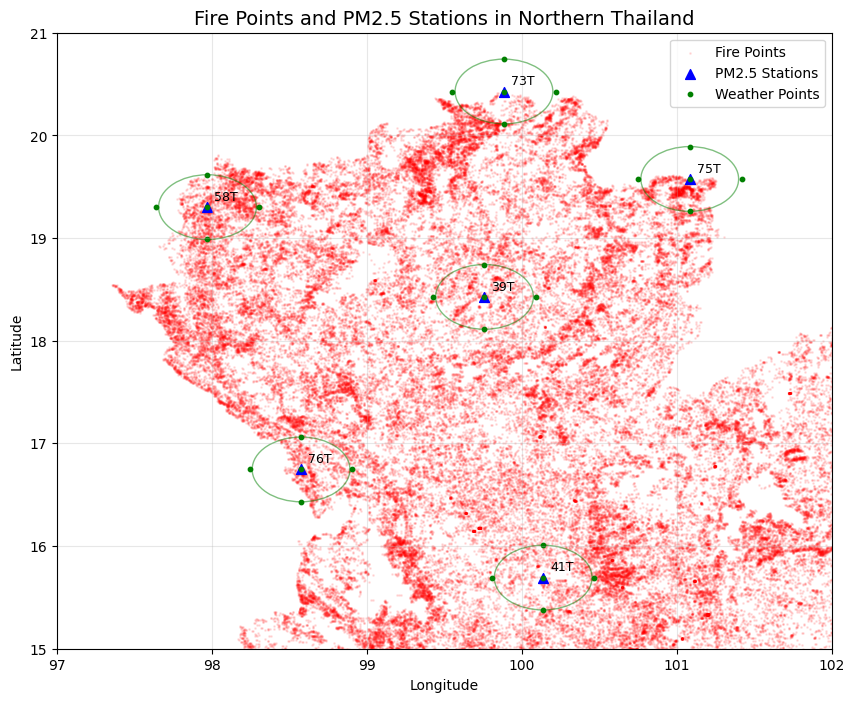

In [20]:
plt.figure(figsize=(10, 8))
plt.xlim(97, 102)
plt.ylim(15, 21)

# Plot fire points (reduce opacity to make station points clearer)
plt.scatter(fire_df['longitude'], fire_df['latitude'], 
           c='red', alpha=0.1, s=1, label='Fire Points')

# Plot PM2.5 station locations
plt.scatter(selected_df['lng'], selected_df['lat'], 
           c='blue', s=50, marker='^', label='PM2.5 Stations')

# Plot weather points
plt.scatter(weather_points['lng'], weather_points['lat'], 
           c='green', s=10, marker='o', label='Weather Points')

# Plot weather points as circular borders around PM2.5 stations
for _, station in selected_df.iterrows():
    circle = plt.Circle((station['lng'], station['lat']), 35/111, color='green', fill=False, alpha=0.5)
    plt.gca().add_patch(circle)



# Add station IDs to points
for _, station in selected_df.iterrows():
    plt.annotate(station['id'], 
                xy=(station['lng'], station['lat']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9)

# Add map details
plt.title('Fire Points and PM2.5 Stations in Northern Thailand', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.legend()

In [21]:
weather_points.to_csv('dataset/Weather/weather_points.csv', index=False)